In [29]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import rasterio
from tqdm import tqdm
import pandas as pd
import gradio as gr

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Load Pretrained SRGAN (ESRGAN)

In [30]:
import torch
from basicsr.archs.rrdbnet_arch import RRDBNet
from basicsr.utils.download_util import load_file_from_url
import os
from typing import Tuple

class SRGANWrapper:
    """
    Enhanced SRGAN (ESRGAN) wrapper with proper input/output handling,
    memory management, and error checking.
    """
    
    def __init__(self, device: torch.device = None):
        """
        Initialize SRGAN model.
        
        Args:
            device: Torch device to use (cuda/cpu). Auto-detects if None.
        """
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        # Initialize model
        self.model = self._init_model()
        self._load_weights()
        
        # Verify model
        self._run_sanity_checks()
    
    def _init_model(self) -> RRDBNet:
        """Initialize the RRDBNet architecture"""
        return RRDBNet(
            num_in_ch=3,
            num_out_ch=3,
            num_feat=64,
            num_block=23,
            num_grow_ch=32,
            scale=4  # 4x upscaling
        ).to(self.device).eval()
    
    def _load_weights(self):
        """Download and load pretrained weights"""
        model_dir = "pretrained_models"
        os.makedirs(model_dir, exist_ok=True)
        
        model_url = "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth"
        model_path = os.path.join(model_dir, "RealESRGAN_x4plus.pth")
        
        if not os.path.exists(model_path):
            model_path = load_file_from_url(model_url, model_dir=model_dir)
        
        state_dict = torch.load(model_path, map_location=self.device)
        
        # Handle different state dict formats
        if 'params_ema' in state_dict:
            self.model.load_state_dict(state_dict['params_ema'])
        elif 'params' in state_dict:
            self.model.load_state_dict(state_dict['params'])
        else:
            self.model.load_state_dict(state_dict)
    
    def _run_sanity_checks(self):
        """Verify model works with different input sizes"""
        test_sizes = [64, 128, 256]  # Test various input sizes
        print("\nRunning sanity checks...")
        
        with torch.no_grad():
            for size in test_sizes:
                dummy_input = torch.randn(1, 3, size, size).to(self.device)
                output = self.model(dummy_input)
                
                expected_size = size * 4
                assert output.shape[2] == expected_size and output.shape[3] == expected_size, \
                    f"Upscaling failed for size {size}x{size}"
                
                print(f"✓ {size}x{size} -> {expected_size}x{expected_size} [OK]")
                torch.cuda.empty_cache()
    
    def upscale(self, image_tensor: torch.Tensor) -> torch.Tensor:
        """
        Enhanced upscaling with proper input/output handling
        
        Args:
            image_tensor: Input tensor (C,H,W) in either [0,1] or [-1,1] range
            
        Returns:
            Upscaled tensor (C,4*H,4*W) in same range as input
        """
        # Input validation
        if not isinstance(image_tensor, torch.Tensor):
            raise TypeError("Input must be a torch.Tensor")
            
        if len(image_tensor.shape) != 3:
            raise ValueError("Input must be 3D tensor (C,H,W)")
            
        if image_tensor.shape[0] != 3:
            raise ValueError("Input must have 3 channels")
        
        # Detect input range
        input_max = image_tensor.max().item()
        was_zero_one = input_max <= 1.0
        
        if was_zero_one and input_max > 1.0:
            raise ValueError("Input tensor appears to be in invalid range")
        
        with torch.no_grad():
            try:
                # Store original device and move to model device
                orig_device = image_tensor.device
                image_tensor = image_tensor.to(self.device)
                
                # Normalize to [-1,1] if needed
                if was_zero_one:
                    image_tensor = image_tensor * 2 - 1
                
                # Upscale
                result = self.model(image_tensor.unsqueeze(0)).squeeze(0)
                
                # Convert back to original range
                if was_zero_one:
                    result = (result + 1) / 2
                
                return result.to(orig_device)
                
            finally:
                # Clean up
                torch.cuda.empty_cache()
    
    def __call__(self, image_tensor: torch.Tensor) -> torch.Tensor:
        """Alias for upscale()"""
        return self.upscale(image_tensor)

 
# Example usage
if __name__ == "__main__":
    # Initialize
    srgan = SRGANWrapper()
    
    # Create test tensor (in [0,1] range)
    test_input = torch.rand(3, 64, 64)  
    
    # Upscale
    try:
        output = srgan.upscale(test_input)
        print(f"\nUpscaling successful! Output shape: {output.shape}")
        
        # Verify output range
        output_min, output_max = output.min().item(), output.max().item()
        print(f"Output range: [{output_min:.2f}, {output_max:.2f}] (should be in [0,1])")
        
    except Exception as e:
        print(f"\nError during upscaling: {str(e)}")

Using device: cuda

Running sanity checks...
✓ 64x64 -> 256x256 [OK]
✓ 128x128 -> 512x512 [OK]
✓ 256x256 -> 1024x1024 [OK]

Upscaling successful! Output shape: torch.Size([3, 256, 256])
Output range: [0.34, 0.62] (should be in [0,1])


### PCA for Band Selection

In [31]:
import numpy as np
import torch
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from typing import Tuple, Union, Optional

def apply_pca(
    tif_img: Union[np.ndarray, torch.Tensor],
    n_components: int = 5,
    pca: Optional[PCA] = None,
    fit: bool = False,
    scaler: Optional[StandardScaler] = None,
    eps: float = 1e-8
) -> Tuple[Union[torch.Tensor, np.ndarray], ...]:
    """
    Enhanced PCA application for spectral band reduction with proper normalization and error handling.
    
    Args:
        tif_img: Input image as (C,H,W) tensor or (H,W,C) numpy array
        n_components: Number of PCA components to keep (default: 5)
        pca: Pre-trained PCA object (required if fit=False)
        fit: Whether to fit new PCA (True) or use existing (False)
        scaler: Pre-trained StandardScaler (required if fit=False and using normalization)
        eps: Small value to prevent division by zero in standardization
        
    Returns:
        If fit=True: (reduced, pca, scaler)
        If fit=False: (reduced, pca)
        
        Where:
        - reduced: Output tensor/array (n_components,H,W)
        - pca: Fitted PCA object
        - scaler: Fitted StandardScaler (only if fit=True)
    
    Raises:
        ValueError: For invalid inputs or inconsistent arguments
        TypeError: For incorrect input types
    """
    # Input validation
    if not isinstance(tif_img, (np.ndarray, torch.Tensor)):
        raise TypeError("Input must be numpy array or torch tensor")
        
    if len(tif_img.shape) != 3:
        raise ValueError("Input must be 3D (C,H,W) or (H,W,C)")
    
    if not fit and pca is None:
        raise ValueError("PCA object must be provided when fit=False")
    
    # Convert tensor to numpy if needed
    if torch.is_tensor(tif_img):
        tif_img = tif_img.cpu().numpy()
    
    # Ensure channels-last format (H,W,C)
    if tif_img.shape[0] < tif_img.shape[-1]:  # Channel-first input
        tif_img = np.moveaxis(tif_img, 0, -1)
    
    original_shape = tif_img.shape
    flattened = tif_img.reshape(-1, original_shape[-1])
    
    # Standardize data (with safety checks)
    if fit:
        scaler = StandardScaler()
        # Handle constant features to avoid division by zero
        flattened = scaler.fit_transform(flattened)
        flattened = np.nan_to_num(flattened, nan=0.0, posinf=0.0, neginf=0.0)
    elif scaler is not None:
        flattened = scaler.transform(flattened)
        flattened = np.nan_to_num(flattened, nan=0.0, posinf=0.0, neginf=0.0)
    
    # Apply PCA with variance checking
    if fit:
        n_components = min(n_components, flattened.shape[1])
        pca = PCA(n_components=n_components)
        reduced = pca.fit_transform(flattened)
        
        # Warn if explained variance is low
        explained_variance = np.sum(pca.explained_variance_ratio_)
        if explained_variance < 0.9:  # 90% threshold
            print(f"Warning: Only {explained_variance:.1%} variance explained with {n_components} components")
    else:
        # Check component compatibility
        if pca.n_components_ != n_components:
            print(f"Warning: Requested {n_components} components but PCA has {pca.n_components_}")
        reduced = pca.transform(flattened)
    
    # Reshape and convert back
    reduced = reduced.reshape(original_shape[0], original_shape[1], -1)  # -1 handles cases where n_components != expected
    
    # Maintain input type (numpy or tensor)
    if isinstance(tif_img, np.ndarray):
        reduced = np.moveaxis(reduced, -1, 0)
    else:
        reduced = torch.from_numpy(np.moveaxis(reduced, -1, 0)).float()
    
    return (reduced, pca, scaler) if fit else (reduced, pca)

 ### Load Dataset Splits & Label Map

In [32]:
import os
import json
import pandas as pd

# Define base directory
base_dir = r"C:\Users\Charan\SEM_FILES\SEM_6\Computer_vision\Project\EuroSAT"

# Load label map
with open(os.path.join(base_dir, "EuroSAT", "label_map.json")) as f:
    label_map = json.load(f)  # Example: {"AnnualCrop": 0, "Forest": 1, ...}

# Reverse mapping: {0: "AnnualCrop", 1: "Forest", ...}
label_map_inv = {v: k for k, v in label_map.items()}

# Load datasets
train_df = pd.read_csv(os.path.join(base_dir, "EuroSAT", "train.csv"))
test_df = pd.read_csv(os.path.join(base_dir, "EuroSAT", "test.csv"))
val_df = pd.read_csv(os.path.join(base_dir, "EuroSAT", "validation.csv"))

# Normalize paths (replace forward slashes with OS-specific separator)
for df in [train_df, test_df, val_df]:
    df["Filename"] = df["Filename"].str.replace("/", os.sep)


# Print dataset sizes
print(f"✅ Final dataset sizes:")
print(f"Train: {len(train_df)} samples ({len(label_map)} classes)")
print(f"Test: {len(test_df)} samples ({len(label_map)} classes)")
print(f"Validation: {len(val_df)} samples ({len(label_map)} classes)")



✅ Final dataset sizes:
Train: 18900 samples (10 classes)
Test: 2700 samples (10 classes)
Validation: 5400 samples (10 classes)


### Custom Dataset Class (SRGAN + PCA)

In [33]:
import os
import torch
from torchvision import transforms
from PIL import Image
import rasterio
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

class EuroSATDataset(torch.utils.data.Dataset):
    def __init__(self, rgb_dir, tif_dir, split_df, transform=None, pca=None, scaler=None, fit=False):
        self.rgb_dir = rgb_dir
        self.tif_dir = tif_dir
        self.split_df = split_df.copy()
        self.transform = transform
        self.pca = pca
        self.scaler = scaler
        self.fit_pca = fit
        self.n_components = 5  # Fixed number of PCA components

        # Standardize paths
        self.split_df['Filename'] = self.split_df['Filename'].str.replace('\\', '/')
        
        # Verify files exist
        self._verify_files_exist()
        
        # Initialize class mappings
        self.classes = sorted(split_df['ClassName'].unique())
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.idx_to_class = {i: cls for i, cls in enumerate(self.classes)}
        
        # Initialize dummy tensors with correct dimensions
        self.dummy_rgb = torch.zeros(3, 64, 64)
        self.dummy_spec = torch.zeros(self.n_components, 64, 64)  # Always 5 channels after PCA
        self.dummy_label = torch.zeros(len(self.classes))

    def _verify_files_exist(self):
        """Verify all files exist and are readable"""
        missing_files = []
        corrupt_files = []
        
        for idx, row in self.split_df.iterrows():
            img_path = os.path.normpath(row['Filename'])
            rgb_path = os.path.join(self.rgb_dir, img_path)
            tif_path = os.path.join(self.tif_dir, img_path.replace('.jpg', '.tif'))
            
            # Check existence
            if not os.path.exists(rgb_path):
                missing_files.append(rgb_path)
                continue
            if not os.path.exists(tif_path):
                missing_files.append(tif_path)
                continue
                
            # Check readability
            try:
                with Image.open(rgb_path) as img:
                    img.verify()
                with rasterio.open(tif_path) as src:
                    _ = src.read()
            except Exception as e:
                corrupt_files.append(f"{rgb_path} or {tif_path} - {str(e)}")
        
        if missing_files or corrupt_files:
            error_msg = []
            if missing_files:
                error_msg.append(f"Missing {len(missing_files)} files. First 3: {missing_files[:3]}")
            if corrupt_files:
                error_msg.append(f"Corrupt {len(corrupt_files)} files. First 3: {corrupt_files[:3]}")
            raise FileNotFoundError("\n".join(error_msg))

    def __len__(self):
        return len(self.split_df)

    # Modify your dataset class's __getitem__ method:
    def __getitem__(self, idx):
        try:
            img_path = os.path.normpath(self.split_df.iloc[idx]['Filename'])
            rgb_path = os.path.join(self.rgb_dir, img_path)
            tif_path = os.path.join(self.tif_dir, img_path.replace('.jpg', '.tif'))

            # Load RGB image
            with Image.open(rgb_path) as img:
                rgb_img = img.convert("RGB")
                rgb_tensor = transforms.ToTensor()(rgb_img).float()

            # Load multi-spectral image
            with rasterio.open(tif_path) as src:
                tif_img = src.read()
                tif_tensor = torch.from_numpy(tif_img).float()

            # Apply PCA reduction
            if self.pca is not None:
                tif_tensor = self._apply_pca(tif_tensor)

            # Apply transforms ONLY to RGB images
            if self.transform:
                rgb_tensor = self.transform(rgb_tensor)
                # Don't transform spectral data

            # Create label tensor
            label_idx = self.split_df.iloc[idx]['Label']
            label_tensor = torch.zeros(len(self.classes), dtype=torch.float32)
            label_tensor[label_idx] = 1.0

            return rgb_tensor, tif_tensor, label_tensor

        except Exception as e:
            print(f"Error loading sample {idx}: {str(e)}")
            return self.dummy_rgb.clone(), self.dummy_spec.clone(), self.dummy_label.clone()

    def _apply_pca(self, tif_tensor):
        """Apply PCA to reduce 13 channels to n_components"""
        try:
            # Convert to numpy and reshape for PCA
            tif_np = tif_tensor.numpy()  # Shape: (13, H, W)
            flattened = tif_np.reshape(13, -1).T  # Shape: (H*W, 13)
            
            # Apply standardization
            if self.scaler is not None:
                flattened = self.scaler.transform(flattened)
            
            # Apply PCA
            if self.pca is not None:
                reduced = self.pca.transform(flattened)  # Shape: (H*W, n_components)
                # Reshape back to image format
                reduced = reduced.T.reshape(self.n_components, *tif_np.shape[1:])  # (n_components, H, W)
                return torch.from_numpy(reduced).float()
            
            return tif_tensor  # Fallback if no PCA
            
        except Exception as e:
            print(f"PCA failed: {str(e)}")
            return torch.zeros(self.n_components, *tif_tensor.shape[1:])  # Return dummy with correct channels


def create_safe_dataloader(dataset, shuffle=True):
    return DataLoader(
        dataset,
        batch_size=8,
        shuffle=shuffle,
        num_workers=0,  # Start with 0 workers for debugging
        pin_memory=False,
        persistent_workers=False,
        prefetch_factor=None,
        worker_init_fn=None
    )

### Phase 2: Model Design (Attention + Multi-Label)
### Cell 7: Cross-Attention Fusion

In [34]:
import torch
import torch.nn as nn

class CrossAttention(nn.Module):
    def __init__(self, channels, num_heads=4, dropout=0.1):
        """
        Enhanced Cross-Attention Module
        
        Args:
            channels: Input channel dimension
            num_heads: Number of attention heads
            dropout: Dropout probability
        """
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = channels // num_heads
        
        assert self.head_dim * num_heads == channels, "channels must be divisible by num_heads"
        
        # Linear projections
        self.query = nn.Linear(channels, channels)
        self.key = nn.Linear(channels, channels)
        self.value = nn.Linear(channels, channels)
        
        # Output projection
        self.proj = nn.Linear(channels, channels)
        
        # Regularization
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(channels)
        
        # Scaling factor
        self.scale = self.head_dim ** -0.5

    def forward(self, rgb_feat, spectral_feat):
        """
        Args:
            rgb_feat: RGB features (B, C, H, W)
            spectral_feat: Spectral features (B, C, H', W')
        Returns:
            Fused features (B, C, H, W)
        """
        B, C, H, W = rgb_feat.shape
        _, _, H_s, W_s = spectral_feat.shape
        
        # Ensure both inputs have the same spatial dimensions
        if (H_s, W_s) != (H, W):
            spectral_feat = nn.functional.interpolate(spectral_feat, size=(H, W), mode='bilinear', align_corners=False)
        
        # Flatten spatial dimensions
        rgb_flat = rgb_feat.view(B, C, -1).permute(0, 2, 1)  # (B, HW, C)
        spectral_flat = spectral_feat.view(B, C, -1).permute(0, 2, 1)  # (B, HW, C)
        
        # Project queries, keys, values
        q = self.query(rgb_flat)  # (B, HW, C)
        k = self.key(spectral_flat)  # (B, HW, C)
        v = self.value(spectral_flat)  # (B, HW, C)
        
        # Split into multiple heads
        q = q.view(B, -1, self.num_heads, self.head_dim).transpose(1, 2)  # (B, nh, HW, hd)
        k = k.view(B, -1, self.num_heads, self.head_dim).transpose(1, 2)  # (B, nh, HW, hd)
        v = v.view(B, -1, self.num_heads, self.head_dim).transpose(1, 2)  # (B, nh, HW, hd)
        
        # Scaled dot-product attention
        attn = (q @ k.transpose(-2, -1)) * self.scale  # (B, nh, HW, HW)
        attn = attn.softmax(dim=-1)
        attn = self.dropout(attn)
        
        # Combine values
        out = (attn @ v).transpose(1, 2).contiguous()  # (B, HW, nh, hd)
        out = out.view(B, -1, C)  # (B, HW, C)
        
        # Project back to channel dimension
        out = self.proj(out)
        out = self.dropout(out)
        
        # Residual connection and layer norm
        out = self.layer_norm(out + rgb_flat)
        
        # Reshape back to spatial dimensions
        out = out.permute(0, 2, 1).view(B, C, H, W)
        
        return out


### Multi-Stream CNN with Attention

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F



class MultiStreamCNN(nn.Module):
    def __init__(self, num_classes=10, attention_heads=4):
        super().__init__()

        self.rgb_cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 256 -> 128
            nn.Conv2d(16, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)   # 128 -> 64
        )

        self.spectral_cnn = nn.Sequential(
            nn.Conv2d(5, 16, kernel_size=3, padding=1, bias=False),  # Changed from 13 → 5
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64 → 32
            nn.Conv2d(16, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)   # 32 → 16
        )

        self.attention = CrossAttention(channels=32, num_heads=attention_heads)

        # Adaptive pooling for dynamic input sizes
        self.pool = nn.AdaptiveAvgPool2d((8, 8))  

        self.fused_dim = 32 * 8 * 8  
        self.total_dim = 3 * self.fused_dim  # RGB + Spectral + Attention

        self.classifier = nn.Sequential(
            nn.Linear(self.total_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)  # No Sigmoid here (correct for BCEWithLogitsLoss)
        )

    def forward(self, rgb, spectral):
        # RGB feature extraction
        rgb_feat = self.rgb_cnn(rgb)
        
        # Spectral feature extraction
        spectral_feat = self.spectral_cnn(spectral)

        # Attention fusion
        fused = self.attention(rgb_feat, spectral_feat)

        # Adaptive pooling for consistent feature size
        rgb_feat = self.pool(rgb_feat)
        spectral_feat = self.pool(spectral_feat)
        fused = self.pool(fused)

        # Flatten and concatenate
        combined = torch.cat([
            torch.flatten(rgb_feat, start_dim=1),
            torch.flatten(spectral_feat, start_dim=1),
            torch.flatten(fused, start_dim=1)
        ], dim=1)

        return self.classifier(combined)


### Training Loop

Using device: cuda

Fitting StandardScaler and PCA...


Loading spectral data: 100%|██████████| 18900/18900 [05:22<00:00, 58.62it/s]


PCA explained variance: 97.22%

Testing data loading...
Batch loaded successfully: [torch.Size([8, 3, 64, 64]), torch.Size([8, 5, 64, 64]), torch.Size([8, 10])]

Epoch 1/50


Train Loss: 0.1666 | Acc: 0.5193
Val Loss: 0.0859 | Acc: 0.7907

Epoch 2/50


Train Loss: 0.1098 | Acc: 0.7125
Val Loss: 0.0602 | Acc: 0.8641

Epoch 3/50


Train Loss: 0.0953 | Acc: 0.7607
Val Loss: 0.0769 | Acc: 0.8159

Epoch 4/50


Train Loss: 0.0867 | Acc: 0.7865
Val Loss: 0.0500 | Acc: 0.8880

Epoch 5/50


Train Loss: 0.0798 | Acc: 0.8061
Val Loss: 0.0456 | Acc: 0.8935

Epoch 6/50


Train Loss: 0.0747 | Acc: 0.8193
Val Loss: 0.0415 | Acc: 0.9031

Epoch 7/50


Train Loss: 0.0715 | Acc: 0.8261
Val Loss: 0.0489 | Acc: 0.8835

Epoch 8/50


Train Loss: 0.0681 | Acc: 0.8355
Val Loss: 0.0380 | Acc: 0.9178

Epoch 9/50


Train Loss: 0.0658 | Acc: 0.8422
Val Loss: 0.0377 | Acc: 0.9174

Epoch 10/50


Train Loss: 0.0618 | Acc: 0.8516
Val Loss: 0.0434 | Acc: 0.8961

Epoch 11/50


Train Loss: 0.0605 | Acc: 0.8539
Val Loss: 0.0452 | Acc: 0.9000

Epoch 12/50


Train Loss: 0.0589 | Acc: 0.8592
Val Loss: 0.0424 | Acc: 0.9024

Epoch 13/50


Train Loss: 0.0519 | Acc: 0.8756
Val Loss: 0.0280 | Acc: 0.9378

Epoch 14/50


Train Loss: 0.0478 | Acc: 0.8864
Val Loss: 0.0304 | Acc: 0.9369

Epoch 15/50


Train Loss: 0.0472 | Acc: 0.8851
Val Loss: 0.0272 | Acc: 0.9407

Epoch 16/50


Train Loss: 0.0468 | Acc: 0.8890
Val Loss: 0.0258 | Acc: 0.9426

Epoch 17/50


Train Loss: 0.0452 | Acc: 0.8907
Val Loss: 0.0290 | Acc: 0.9354

Epoch 18/50


Train Loss: 0.0444 | Acc: 0.8940
Val Loss: 0.0281 | Acc: 0.9369

Epoch 19/50


Train Loss: 0.0426 | Acc: 0.8970
Val Loss: 0.0278 | Acc: 0.9422

Epoch 20/50


Train Loss: 0.0396 | Acc: 0.9071
Val Loss: 0.0242 | Acc: 0.9476

Epoch 21/50


Train Loss: 0.0377 | Acc: 0.9117
Val Loss: 0.0241 | Acc: 0.9457

Epoch 22/50


Train Loss: 0.0382 | Acc: 0.9100
Val Loss: 0.0242 | Acc: 0.9439

Epoch 23/50


Train Loss: 0.0369 | Acc: 0.9133
Val Loss: 0.0242 | Acc: 0.9494

Epoch 24/50


Train Loss: 0.0363 | Acc: 0.9090
Val Loss: 0.0242 | Acc: 0.9454

Epoch 25/50


Train Loss: 0.0352 | Acc: 0.9176
Val Loss: 0.0229 | Acc: 0.9496

Epoch 26/50


Train Loss: 0.0332 | Acc: 0.9192
Val Loss: 0.0220 | Acc: 0.9546

Epoch 27/50


Train Loss: 0.0340 | Acc: 0.9179
Val Loss: 0.0226 | Acc: 0.9494

Epoch 28/50


Train Loss: 0.0326 | Acc: 0.9227
Val Loss: 0.0228 | Acc: 0.9517

Epoch 29/50


Train Loss: 0.0332 | Acc: 0.9218
Val Loss: 0.0211 | Acc: 0.9528

Epoch 30/50


Train Loss: 0.0326 | Acc: 0.9222
Val Loss: 0.0205 | Acc: 0.9552

Epoch 31/50


Train Loss: 0.0331 | Acc: 0.9215
Val Loss: 0.0213 | Acc: 0.9546

Epoch 32/50


Train Loss: 0.0324 | Acc: 0.9252
Val Loss: 0.0203 | Acc: 0.9535

Epoch 33/50


Train Loss: 0.0317 | Acc: 0.9222
Val Loss: 0.0225 | Acc: 0.9491

Epoch 34/50


Train Loss: 0.0313 | Acc: 0.9253
Val Loss: 0.0211 | Acc: 0.9544

Epoch 35/50


Train Loss: 0.0311 | Acc: 0.9242
Val Loss: 0.0221 | Acc: 0.9498

Epoch 36/50


Train Loss: 0.0306 | Acc: 0.9266
Val Loss: 0.0205 | Acc: 0.9543

Epoch 37/50


Train Loss: 0.0310 | Acc: 0.9267
Val Loss: 0.0208 | Acc: 0.9544
Early stopping after 5 epochs without improvement

Final Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop     0.9385    0.9220    0.9302     22200
              Forest     0.9591    0.9899    0.9743     22200
HerbaceousVegetation     0.9135    0.9441    0.9286     22200
             Highway     0.9429    0.8799    0.9103     18500
          Industrial     0.9529    0.9589    0.9559     18500
             Pasture     0.9231    0.8500    0.8850     14800
       PermanentCrop     0.9036    0.8886    0.8960     18500
         Residential     0.9559    0.9564    0.9562     22200
               River     0.9507    0.9591    0.9549     18500
             SeaLake     0.9968    0.9859    0.9913     22200

           micro avg     0.9450    0.9374    0.9412    199800
           macro avg     0.9437    0.9335    0.9383    199800
        weighted avg     0.9449    0.9374    0.9

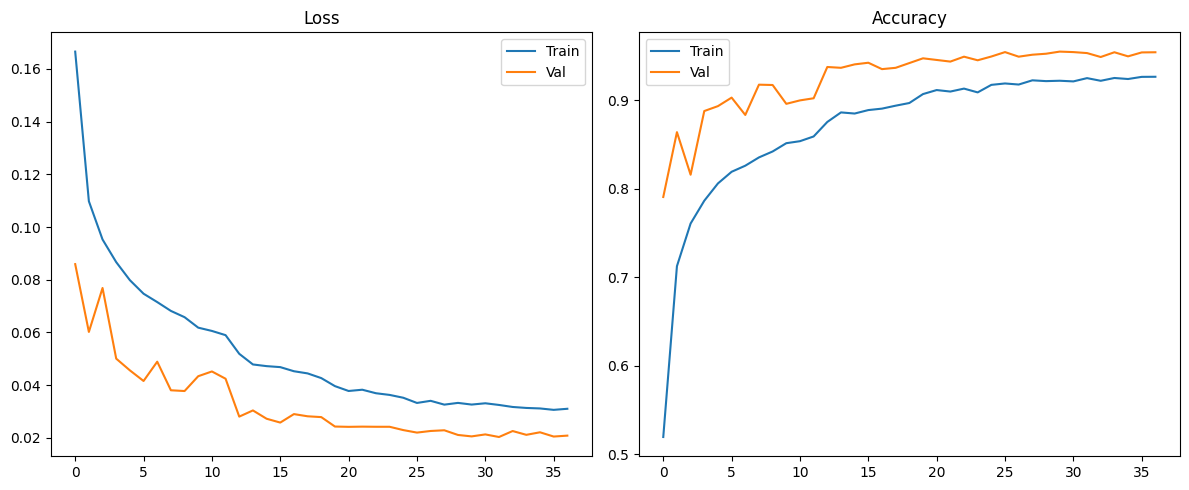

Training complete!


In [166]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from torchvision import transforms
import pandas as pd
import json
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import rasterio
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
BATCH_SIZE = 16
LEARNING_RATE = 0.001
EPOCHS = 50
PATIENCE = 5
N_COMPONENTS = 5
PREFETCH_FACTOR = 1
NUM_WORKERS = 0

# Define base directory
base_dir = r"C:\Users\Charan\SEM_FILES\SEM_6\Computer_vision\Project\EuroSAT"

# Load label map
with open(os.path.join(base_dir, "EuroSAT", "label_map.json")) as f:
    label_map = json.load(f)
label_map_inv = {v: k for k, v in label_map.items()}

# Robust dataset loading with validation
def load_and_validate_data():
    train_df = pd.read_csv(os.path.join(base_dir, "EuroSAT", "train.csv"))
    val_df = pd.read_csv(os.path.join(base_dir, "EuroSAT", "validation.csv"))
    
    # Verify file existence
    def validate_files(df):
        missing = []
        for idx, row in df.iterrows():
            rgb_path = os.path.join(base_dir, "EuroSAT", row['Filename'])
            tif_path = os.path.join(base_dir, "EuroSATallBands", row['Filename'].replace('.jpg', '.tif'))
            if not os.path.exists(rgb_path):
                missing.append(rgb_path)
            if not os.path.exists(tif_path):
                missing.append(tif_path)
        return missing
    
    missing_train = validate_files(train_df)
    missing_val = validate_files(val_df)
    
    if missing_train or missing_val:
        raise FileNotFoundError(f"Missing files:\nTrain: {missing_train[:3]}\nVal: {missing_val[:3]}")
    
    return train_df, val_df

train_df, val_df = load_and_validate_data()

# Initialize PCA and Scaler
print("\nFitting StandardScaler and PCA...")
spectral_data = []
for _, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Loading spectral data"):
    tif_path = os.path.join(base_dir, "EuroSATallBands", row['Filename'].replace('.jpg', '.tif'))
    with rasterio.open(tif_path) as src:
        bands = src.read()  # (13, H, W)
        spectral_data.append(bands.reshape(13, -1).T)  # (H*W, 13)

spectral_data = np.concatenate(spectral_data)  # (N*H*W, 13)
scaler = StandardScaler()
scaler.fit(spectral_data)
scaled_data = scaler.transform(spectral_data)

pca = PCA(n_components=N_COMPONENTS)
pca.fit(scaled_data)
print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")

# Initialize model
model = MultiStreamCNN(num_classes=len(label_map), attention_heads=4).to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
grad_scaler = torch.amp.GradScaler()

# Create datasets
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)
])

train_dataset = EuroSATDataset(
    rgb_dir=os.path.join(base_dir, "EuroSAT"),
    tif_dir=os.path.join(base_dir, "EuroSATallBands"),
    split_df=train_df,
    transform=train_transform,
    pca=pca,
    scaler=scaler
)

val_dataset = EuroSATDataset(
    rgb_dir=os.path.join(base_dir, "EuroSAT"),
    tif_dir=os.path.join(base_dir, "EuroSATallBands"),
    split_df=val_df,
    transform=None,
    pca=pca,
    scaler=scaler
)


train_loader = create_safe_dataloader(train_dataset, shuffle=True)
val_loader = create_safe_dataloader(val_dataset, shuffle=False)

def train_epoch(model, loader, optimizer, criterion, grad_scaler, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc="Training", leave=False)
    for rgb, spectral, labels in pbar:
        rgb = rgb.to(device, non_blocking=True)
        spectral = spectral.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        # Modified autocast with device_type
        with torch.amp.autocast(device_type='cuda' if 'cuda' in str(device) else 'cpu'):
            outputs = model(rgb, spectral)
            loss = criterion(outputs, labels)
        
        optimizer.zero_grad(set_to_none=True)
        grad_scaler.scale(loss).backward()
        grad_scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        grad_scaler.step(optimizer)
        grad_scaler.update()
        
        running_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == labels).all(dim=1).sum().item()
        total += labels.size(0)
        
        pbar.set_postfix({
            'loss': running_loss / (pbar.n + 1),
            'acc': correct / total
        })
    
    return running_loss / len(loader), correct / total

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        pbar = tqdm(loader, desc="Validation", leave=False)
        for rgb, spectral, labels in pbar:
            rgb = rgb.to(device, non_blocking=True)
            spectral = spectral.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            # Modified autocast with device_type
            with torch.amp.autocast(device_type='cuda' if 'cuda' in str(device) else 'cpu'):
                outputs = model(rgb, spectral)
                loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == labels).all(dim=1).sum().item()
            total += labels.size(0)
            
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
    
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    
    return running_loss / len(loader), correct / total, all_preds, all_labels

if __name__ == '__main__':
    # Windows-specific multiprocessing fix
    import multiprocessing
    multiprocessing.freeze_support()
    
    
    # Verify data loading
    print("\nTesting data loading...")
    try:
        test_batch = next(iter(train_loader))
        print(f"Batch loaded successfully: {[t.shape for t in test_batch]}")
    except Exception as e:
        print(f"Data loading failed: {str(e)}")
        exit(1)

    # Training loop
    best_val_loss = float('inf')
    patience_counter = 0
    train_history = {'loss': [], 'acc': [], 'val_loss': [], 'val_acc': []}

    all_val_preds = []
    all_val_labels = []

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch + 1}/{EPOCHS}")
        
        try:
            train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, grad_scaler, device)
            val_loss, val_acc, val_preds, val_labels = validate(model, val_loader, criterion, device)

            # Store predictions for final report
            all_val_preds.append(val_preds)
            all_val_labels.append(val_labels)

        except RuntimeError as e:
            if "CUDA out of memory" in str(e):
                torch.cuda.empty_cache()
                print("Reducing batch size and trying again...")
                BATCH_SIZE = max(8, BATCH_SIZE // 2)
                train_loader = create_safe_dataloader(train_dataset, shuffle=True)
                val_loader = create_safe_dataloader(val_dataset, shuffle=False)
                continue
            elif "DataLoader worker" in str(e):
                print("DataLoader worker failed, reducing num_workers...")
                train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
                val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
                continue
            else:
                raise
        
        scheduler.step(val_loss)
        
        train_history['loss'].append(train_loss)
        train_history['acc'].append(train_acc)
        train_history['val_loss'].append(val_loss)
        train_history['val_acc'].append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")
        final_preds = np.concatenate(all_val_preds)
        final_labels = np.concatenate(all_val_labels)
        
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
                'metrics': train_history,
                'pca': pca,
                'scaler': scaler
            }, "best_model.pth")
            
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"Early stopping after {PATIENCE} epochs without improvement")
                break
    
    print("\nFinal Classification Report:")
    print(classification_report(
            final_labels, 
            final_preds, 
            target_names=list(label_map.keys()), 
            digits=4
            ))

    # Plot results
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_history['loss'], label='Train')
    plt.plot(train_history['val_loss'], label='Val')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_history['acc'], label='Train')
    plt.plot(train_history['val_acc'], label='Val')
    plt.title('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.show()

    print("Training complete!")

### Evaluation Metrics

Looking for spectral data at: C:\Users\Charan\SEM_FILES\SEM_6\Computer_vision\Project\EuroSAT\EuroSATallBands\River\River_1209.tif

Top 2 Predictions for River_1209.jpg:
PermanentCrop: 0.3418
River: 0.0313


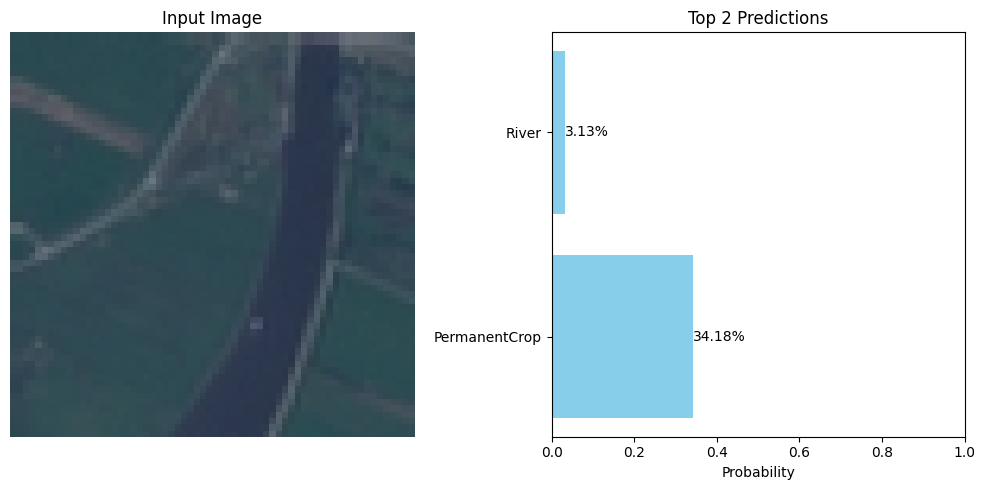

In [44]:
# Testing Code for Jupyter Notebook
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
import rasterio
import os
import json
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.decomposition import PCA

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_dir = r"C:\Users\Charan\SEM_FILES\SEM_6\Computer_vision\Project\EuroSAT"
N_COMPONENTS = 5  # Should match your training setup

# Load label map
with open(os.path.join(base_dir, "EuroSAT", "label_map.json")) as f:
    label_map = json.load(f)
label_map_inv = {v: k for k, v in label_map.items()}

def load_model(model_path, num_classes):
    """Load the saved model from checkpoint"""
    # Add PCA to safe globals before loading
    torch.serialization.add_safe_globals([PCA])
    
    # Load with weights_only=False since we trust the source
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    # Initialize model architecture (using the class defined in this notebook)
    model = MultiStreamCNN(num_classes=num_classes).to(device)
    
    # Load trained weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    return model, checkpoint['pca'], checkpoint['scaler']

# Load the model and preprocessing components
model, pca, scaler = load_model("best_model.pth", len(label_map))

def preprocess_rgb(image_path):
    """Preprocess RGB image for model input"""
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225])
    ])
    img = Image.open(image_path).convert('RGB')
    return transform(img).unsqueeze(0)  # Add batch dimension

def preprocess_spectral(tif_path, pca, scaler):
    """Preprocess multi-spectral image using PCA"""
    with rasterio.open(tif_path) as src:
        bands = src.read()  # (13, H, W)
    
    # Flatten and standardize
    h, w = bands.shape[1], bands.shape[2]
    flattened = bands.reshape(13, -1).T  # (H*W, 13)
    scaled = scaler.transform(flattened)
    
    # Apply PCA
    reduced = pca.transform(scaled)  # (H*W, n_components)
    reduced = reduced.T.reshape(N_COMPONENTS, h, w)  # (n_components, H, W)
    
    # Convert to tensor and resize
    tensor = torch.from_numpy(reduced).float()
    tensor = torch.nn.functional.interpolate(
        tensor.unsqueeze(0), 
        size=(64, 64), 
        mode='bilinear'
    )
    return tensor.squeeze(0)

def predict_top2(image_path):
    """Make prediction and return top 2 classes with probabilities"""
    # Get corresponding TIFF path - corrected to use image_path parameter
    relative_path = os.path.relpath(image_path, start=os.path.join(base_dir, "EuroSAT"))
    tif_path = os.path.join(base_dir, "EuroSATallBands", relative_path.replace(".jpg", ".tif"))
    
    print(f"Looking for spectral data at: {tif_path}")  # Debug output
    
    if not os.path.exists(tif_path):
        raise FileNotFoundError(f"Spectral data not found at {tif_path}")
    
    # Rest of the function remains the same...
    rgb_tensor = preprocess_rgb(image_path).to(device)
    spectral_tensor = preprocess_spectral(tif_path, pca, scaler).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(rgb_tensor, spectral_tensor)
        probs = torch.sigmoid(outputs).squeeze().cpu().numpy()
    
    top2_indices = np.argsort(probs)[-2:][::-1]
    top2_classes = [label_map_inv[i] for i in top2_indices]
    top2_probs = [probs[i] for i in top2_indices]
    
    
    return top2_classes, top2_probs

def visualize_prediction(image_path, top2_classes, top2_probs):
    """Visualize input image and predictions"""
    img = Image.open(image_path)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Input Image')
    
    plt.subplot(1, 2, 2)
    plt.barh(top2_classes, top2_probs, color='skyblue')
    plt.xlabel('Probability')
    plt.title('Top 2 Predictions')
    plt.xlim(0, 1)
    
    for i, prob in enumerate(top2_probs):
        plt.text(prob, i, f"{prob*100:.2f}%", va='center')
    
    plt.tight_layout()
    plt.show()

# Test with a sample image
sample_image = os.path.join(base_dir, "EuroSAT", "River", "River_1209.jpg")

if os.path.exists(sample_image):
    try:
        classes, probs = predict_top2(sample_image)
        print(f"\nTop 2 Predictions for {os.path.basename(sample_image)}:")
        for cls, prob in zip(classes, probs):
            print(f"{cls}: {prob:.4f}")
        
        visualize_prediction(sample_image, classes, probs)
    except Exception as e:
        print(f"Error during prediction: {str(e)}")
else:
    print(f"Image not found at {sample_image}")
    print("Please provide a valid path to an image from your EuroSAT dataset")

### Gradio App

In [ ]:
import gradio as gr
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import rasterio
import tempfile
import os

# Load model and preprocessing components (should be defined before the predict function)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, pca, scaler = load_model("best_model.pth", len(label_map))

def preprocess_spectral(tif_array, pca, scaler):
    """Preprocess multi-spectral numpy array using PCA"""
    # Flatten and standardize
    h, w = tif_array.shape[1], tif_array.shape[2]
    flattened = tif_array.reshape(13, -1).T  # (H*W, 13)
    scaled = scaler.transform(flattened)
    
    # Apply PCA
    reduced = pca.transform(scaled)  # (H*W, n_components)
    reduced = reduced.T.reshape(N_COMPONENTS, h, w)  # (n_components, H, W)
    
    # Convert to tensor and resize
    tensor = torch.from_numpy(reduced).float()
    tensor = torch.nn.functional.interpolate(
        tensor.unsqueeze(0), 
        size=(64, 64), 
        mode='bilinear'
    )
    return tensor.squeeze(0)

def predict(rgb_img, tif_file):
    """Make prediction and return top 2 classes with probabilities"""
    try:
        # Get the file path from the uploaded file dictionary
        tif_path = tif_file.name
        
        # Read the TIFF file with rasterio
        with rasterio.open(tif_path) as src:
            tif_array = src.read()  # Read all bands (13, H, W)
        
        # Preprocess RGB image
        transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
        rgb_tensor = transform(Image.fromarray(rgb_img)).unsqueeze(0).to(device)
        
        # Preprocess spectral data (now passing pca and scaler)
        spectral_tensor = preprocess_spectral(tif_array, pca, scaler).unsqueeze(0).to(device)
        
        # Predict
        with torch.no_grad():
            outputs = model(rgb_tensor, spectral_tensor)
            probs = torch.sigmoid(outputs).squeeze().cpu().numpy()
        
        # Get top 2 predictions
        top2_indices = np.argsort(probs)[-2:][::-1]
        top2_classes = [label_map_inv[i] for i in top2_indices]
        top2_probs = [probs[i] for i in top2_indices]
        
        # Create a bar plot
        fig, ax = plt.subplots(figsize=(8, 4))
        bars = ax.barh(top2_classes, top2_probs, color='skyblue')
        ax.set_xlim(0, 1)
        ax.set_title('Top 2 Predictions')
        ax.set_xlabel('Probability')
        
        # Add probability values to the bars
        for bar, prob in zip(bars, top2_probs):
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2, 
                   f'{prob:.4f}', 
                   va='center', ha='left', fontsize=10)
        
        plt.tight_layout()
        return fig
        
    except Exception as e:
        print(f"Error during prediction: {str(e)}")
        raise gr.Error(f"Prediction failed: {str(e)}")

# Create Gradio interface
with gr.Blocks(title="EuroSAT Land Cover Classification") as demo:
    gr.Markdown("# EuroSAT Land Cover Classification")
    gr.Markdown("Upload RGB and corresponding multi-spectral images for classification")
    
    with gr.Row():
        rgb_input = gr.Image(label="RGB Image (JPG/PNG)")
        tif_input = gr.File(label="Multi-spectral Image (TIFF)", file_types=[".tif"])
    
    submit_btn = gr.Button("Classify")
    
    with gr.Row():
        output_plot = gr.Plot(label="Top 2 Predictions")
    
    submit_btn.click(
        fn=predict,
        inputs=[rgb_input, tif_input],
        outputs=output_plot
    )

demo.launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [ ]:
import os

# Load model and preprocessing components (should be defined before the predict function)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, pca, scaler = load_model("best_model.pth", len(label_map))

def preprocess_spectral(tif_array, pca, scaler):
    """Preprocess multi-spectral numpy array using PCA"""
    # Flatten and standardize
    h, w = tif_array.shape[1], tif_array.shape[2]
    flattened = tif_array.reshape(13, -1).T  # (H*W, 13)
    scaled = scaler.transform(flattened)
    
    # Apply PCA
    reduced = pca.transform(scaled)  # (H*W, n_components)
    reduced = reduced.T.reshape(N_COMPONENTS, h, w)  # (n_components, H, W)
    
    # Convert to tensor and resize
    tensor = torch.from_numpy(reduced).float()
    tensor = torch.nn.functional.interpolate(
        tensor.unsqueeze(0), 
        size=(64, 64), 
        mode='bilinear'
    )
    return tensor.squeeze(0)

def predict(rgb_img, tif_file):
    """Make prediction and return top 2 classes with probabilities"""
    try:
        # Get the file path from the uploaded file dictionary
        tif_path = tif_file.name
        
        # Read the TIFF file with rasterio
        with rasterio.open(tif_path) as src:
            tif_array = src.read()  # Read all bands (13, H, W)
        
        # Preprocess RGB image
        transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
        rgb_tensor = transform(Image.fromarray(rgb_img)).unsqueeze(0).to(device)
        
        # Preprocess spectral data (now passing pca and scaler)
        spectral_tensor = preprocess_spectral(tif_array, pca, scaler).unsqueeze(0).to(device)
        
        # Predict
        with torch.no_grad():
            outputs = model(rgb_tensor, spectral_tensor)
            probs = torch.sigmoid(outputs).squeeze().cpu().numpy()
        
        # Get top 2 predictions
        top2_indices = np.argsort(probs)[-2:][::-1]
        top2_classes = [label_map_inv[i] for i in top2_indices]
        top2_probs = [probs[i] for i in top2_indices]
        
        # Create a bar plot
        fig, ax = plt.subplots(figsize=(8, 4))
        bars = ax.barh(top2_classes, top2_probs, color='skyblue')
        ax.set_xlim(0, 1)
        ax.set_title('Top 2 Predictions')
        ax.set_xlabel('Probability')
        
        # Add probability values to the bars
        for bar, prob in zip(bars, top2_probs):
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2, 
                   f'{prob:.4f}', 
                   va='center', ha='left', fontsize=10)
        
        plt.tight_layout()
        return fig
        
    except Exception as e:
        print(f"Error during prediction: {str(e)}")
        raise gr.Error(f"Prediction failed: {str(e)}")

# Create Gradio interface
with gr.Blocks(title="EuroSAT Land Cover Classification") as demo:
    gr.Markdown("# EuroSAT Land Cover Classification")
    gr.Markdown("Upload RGB and corresponding multi-spectral images for classification")
    
    with gr.Row():
        rgb_input = gr.Image(label="RGB Image (JPG/PNG)")
        tif_input = gr.File(label="Multi-spectral Image (TIFF)", file_types=[".tif"])
    
    submit_btn = gr.Button("Classify")
    
    with gr.Row():
        output_plot = gr.Plot(label="Top 2 Predictions")
    
    submit_btn.click(
        fn=predict,
        inputs=[rgb_input, tif_input],
        outputs=output_plot
    )

demo.launch()

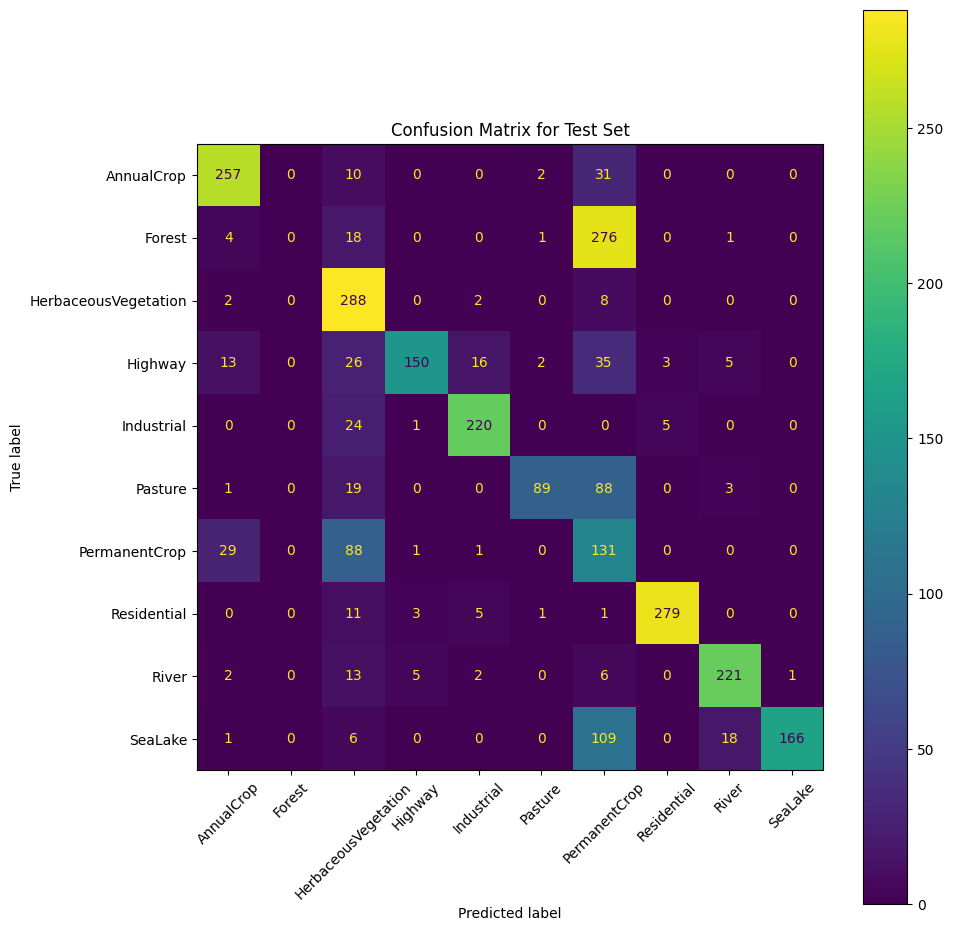

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map_inv[i] for i in range(len(label_map))])
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(include_values=True, cmap='viridis', ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix for Test Set")
plt.tight_layout()
plt.show()


In [20]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import numpy as np
from tqdm import tqdm
import os
import pandas as pd

# Ensure device is defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model (using weights_only=False since checkpoint includes PCA/scaler)
model_path = "best_model.pth"
checkpoint = torch.load(model_path, map_location=device, weights_only=False)
model = MultiStreamCNN(num_classes=len(label_map)).to(device)  # Replace with your model class
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Define base directory
base_dir = r"C:\Users\Charan\SEM_FILES\SEM_6\Computer_vision\Project\EuroSAT"

# Load label map
with open(os.path.join(base_dir, "EuroSAT", "label_map.json")) as f:
    label_map = json.load(f)

# Load dataset splits with full sizes
train_df = pd.read_csv(os.path.join(base_dir, "EuroSAT", "train.csv"))
val_df = pd.read_csv(os.path.join(base_dir, "EuroSAT", "validation.csv"))
test_df = pd.read_csv(os.path.join(base_dir, "EuroSAT", "test.csv"))
# Recreate datasets and dataloaders (using classes defined in cell 6)
train_dataset = EuroSATDataset(
    rgb_dir=os.path.join(base_dir, "EuroSAT"),
    tif_dir=os.path.join(base_dir, "EuroSATallBands"),
    split_df=train_df,
    transform=None,
    pca=checkpoint.get('pca', None),
    scaler=checkpoint.get('scaler', None)
)
val_dataset = EuroSATDataset(
    rgb_dir=os.path.join(base_dir, "EuroSAT"),
    tif_dir=os.path.join(base_dir, "EuroSATallBands"),
    split_df=val_df,
    transform=None,
    pca=checkpoint.get('pca', None),
    scaler=checkpoint.get('scaler', None)
)
test_dataset = EuroSATDataset(
    rgb_dir=os.path.join(base_dir, "EuroSAT"),
    tif_dir=os.path.join(base_dir, "EuroSATallBands"),
    split_df=test_df,
    transform=None,
    pca=checkpoint.get('pca', None),
    scaler=checkpoint.get('scaler', None)
)

train_loader = create_safe_dataloader(train_dataset, shuffle=False)
val_loader = create_safe_dataloader(val_dataset, shuffle=False)
test_loader = create_safe_dataloader(test_dataset, shuffle=False)

# Function to get predictions and labels
def get_predictions_and_labels(loader):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for rgb, spectral, labels in tqdm(loader, desc="Evaluating"):
            rgb = rgb.to(device)
            spectral = spectral.to(device)
            labels = labels.to(device)
            outputs = model(rgb, spectral)
            preds = (torch.sigmoid(outputs) > 0.5).float()  # Threshold at 0.5
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    return np.concatenate(all_preds), np.concatenate(all_labels)

# Get predictions and labels for all sets
train_preds, train_labels = get_predictions_and_labels(train_loader)
val_preds, val_labels = get_predictions_and_labels(val_loader)
test_preds, test_labels = get_predictions_and_labels(test_loader)

# Compute class-wise accuracy
def classwise_accuracy(preds, labels):
    accuracies = []
    for class_idx in range(preds.shape[1]):  # Iterate over each class
        class_preds = preds[:, class_idx]
        class_labels = labels[:, class_idx]
        correct = (class_preds == class_labels).sum()
        total = class_labels.size
        accuracy = correct / total
        accuracies.append(accuracy)
    return accuracies

train_accuracies = classwise_accuracy(train_preds, train_labels)
val_accuracies = classwise_accuracy(val_preds, val_labels)
test_accuracies = classwise_accuracy(test_preds, test_labels)

# Print results in structured format like the classification report
print("\n Accuracy Report:")
print(" " * 20 + "train    val    test")
for class_name, train_acc, val_acc, test_acc in zip(label_map.keys(), train_accuracies, val_accuracies, test_accuracies):
    print(f"{class_name:<20} {train_acc:.4f}  {val_acc:.4f}  {test_acc:.4f}")

Evaluating: 100%|██████████| 338/338 [00:32<00:00, 10.30it/s]


 Accuracy Report:
                    train    val    test
AnnualCrop           0.9952  0.9898  0.9904
Forest               0.9981  0.9978  0.9981
HerbaceousVegetation 0.9915  0.9887  0.9889
Highway              0.9963  0.9907  0.9885
Industrial           0.9989  0.9950  0.9941
Pasture              0.9950  0.9893  0.9930
PermanentCrop        0.9932  0.9881  0.9848
Residential          0.9992  0.9961  0.9974
River                0.9981  0.9939  0.9930
SeaLake              0.9996  0.9985  0.9978


In [27]:
import pandas as pd
import os

# Count samples per class in each dataset
def count_samples_per_class(df, label_map):
    class_counts = {cls: 0 for cls in label_map.keys()}
    if 'Label' not in df.columns:
        raise KeyError("Column 'Label' not found in DataFrame. Please check your CSV structure.")
    
    for idx, row in df.iterrows():
        cls_idx = row['Label']  # Single label index
        cls_name = list(label_map.keys())[cls_idx]  # Map index to class name
        class_counts[cls_name] += 1
    return class_counts

# Define base directory
base_dir = r"C:\Users\Charan\SEM_FILES\SEM_6\Computer_vision\Project\EuroSAT"

# Load label map
with open(os.path.join(base_dir, "EuroSAT", "label_map.json")) as f:
    label_map = json.load(f)

# Load dataset splits with full sizes
train_df = pd.read_csv(os.path.join(base_dir, "EuroSAT", "train.csv"))  # 18,900 samples
val_df = pd.read_csv(os.path.join(base_dir, "EuroSAT", "validation.csv"))  # 5,400 samples
test_df = pd.read_csv(os.path.join(base_dir, "EuroSAT", "test.csv"))  # 2,700 samples

# Count samples per class
train_counts = count_samples_per_class(train_df, label_map)
val_counts = count_samples_per_class(val_df, label_map)
test_counts = count_samples_per_class(test_df, label_map)

# Print results with sample counts
print("\nSample Counts per Class:\n")
print(" " * 20 + "train_cnt  val_cnt  test_cnt")
for class_name, train_cnt, val_cnt, test_cnt in zip(
    label_map.keys(),
    [train_counts[cls] for cls in label_map.keys()],
    [val_counts[cls] for cls in label_map.keys()],
    [test_counts[cls] for cls in label_map.keys()]
):
    print(f"{class_name:<20} {train_cnt:4d}     {val_cnt:4d}     {test_cnt:4d}")


Sample Counts per Class:

                    train_cnt  val_cnt  test_cnt
AnnualCrop           2100      600      300
Forest               2100      600      300
HerbaceousVegetation 2100      600      300
Highway              1750      500      250
Industrial           1750      500      250
Pasture              1400      400      200
PermanentCrop        1750      500      250
Residential          2100      600      300
River                1750      500      250
SeaLake              2100      600      300
